In [180]:
import numpy as np

subsolver = lambda x, g, A, m, M: max(m-x, min(M-x, -(g/A)))

#f_2d = lambda x: 0.5*A[0,0]*x[0]**2+0.5*A[1,1]*x[1]**2+A[0,1]*x[0]*x[1]+b[0]*x[0]+b[1]*x[1]

def exact_2d(A, b, m, M):
	f = lambda x: 0.5*x.T@A@x+b.T@x
	x = -(np.linalg.inv(A)@b)
	if (x[0]<=M[0] and x[1]<=M[1]) and (x[0]>=m[0] and x[1]>=m[1]):
		return x #satisfy, we are done
	minimum=np.inf #initialize minimum of function_2d as infinity
	minimum_x=[]
	#x = np.array([m.sum()/2,M.sum()/2]) #initialize x as middle point of m and M
	x = (M+m)/2
	for i in range(2): #2d
		for _,Mm in enumerate([m, M]):
			j=1-i #another dimension (if i==0 then j=1, if i==1 then j=0)
			x[i]=Mm[i] #consider all cases: x1=m1;x1=M1;x2=m2;x2=M2
			g=A@x+b
			x[j]+=subsolver(x[j], g[j], A[j,j], m[j], M[j]) #calculate another dimension
			if(f(x)<minimum): #update minimum
				minimum_x=x.copy() #update to the list
				minimum=f(x) #new minimum
	return minimum_x

def kkt(x, g, m, M):
	h=np.zeros_like(g)
	if(isinstance(x,float)==False):
		for i in range(len(h)):
			'''
			if (x[i]==m[i] and g[i]>0):
				h[i]=0
			elif (x[i]==M[i] and g[i]<0):
				h[i]=0
			'''
			if not (x[i]==m[i] and g[i]>0) and not (x[i]==M[i] and g[i]<0):
				h[i]=g[i]
	else:
		if not (x==m and g>0) and not (x==M and g<0):
			h=g
	return h

def coord_descent(A, b, m, M, epsilon=1e-16, max_iter=10000):
	f = lambda x: 0.5*x.T@A@x+b.T@x
	x=-(np.linalg.inv(A)@b) #try Newton
	if(x<=M).all() and (x>=m).all(): #Newton step, one iter, no g, no h
		return x, 1, [x], [f(x)], [], []
	#x=np.array([m.sum()/2,M.sum()/2]) #center as initial point
	x = (M+m)/2
	all_x=[]; all_y=[]; all_g=[]; all_h=[]
	if(isinstance(x,float)==False):
		all_x.append([x[k] for k in range(x.shape[0])])
		all_y.append(f(x))
		g=A@x+b
	else:
		all_x.append(x)
		all_y.append(f(np.matrix(x)))
		g=A@np.matrix(x)+b
	it=0
	stop=False
	while(stop is not True):
		if(isinstance(x,float)==False):
			for i in range(x.shape[0]):
				alpha = subsolver(x[i], g[i], A[i,i], m[i], M[i]) #view alpha as vector
				x[i]+=alpha
				g=g+alpha*A[i] #upgrade gradient
				all_g.append(g)
				h=kkt(x, g, m, M) #deal as matrix
				all_h.append(h)
				all_x.append([x[k] for k in range(x.shape[0])])
				#print(x,all_x)
				all_y.append(f(x))
				it+=1
				if np.linalg.norm(h)<epsilon or it>=max_iter:
					stop=True
					break
		else:
			alpha = subsolver(x, g, A, m, M) #view alpha as single number
			x+=alpha
			g=g+alpha*A
			all_g.append(g)
			h=kkt(x, g, m, M)
			all_h.append(h)
			all_x.append(x)
			all_y.append(f(np.matrix(x)))
			it+=1
			if np.linalg.norm(h)<epsilon or it>=max_iter:
				stop=True
				break
	return x, it, all_x, all_y, all_g, all_h

def gen_2d_prob(beta=0.99999, mean=0, std=0.01):
	A=np.array([[1,beta],[beta,1]])
	m=np.array([-3,-3])
	M=np.array([-1,-1])
	b=np.random.normal(mean, std, 2) #2d
	return A, b, m, M

def gen_prob(d, mean=0, std=0.01):
	B = np.random.normal(size=(d,d))
	A = B@B.T
	m = -np.ones(d)
	M = np.ones(d)
	b = np.random.normal(mean, std, d)
	return A, b, m, M

[-1. -1.] [-1. -1.]


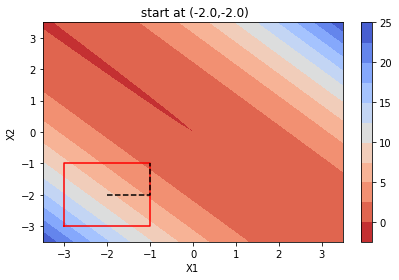

In [181]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

def init_x(step,start,end,dimension): #set the start&end coord, step size and dimension number pf input set
    xi=np.arange(start, end, step); x=xi #initialization of input xi for each dimension
    for i in range(dimension-1):
        x=np.vstack((np.around(x,decimals=9),np.around(xi,decimals=9))) #make x to d dimensions, from xi
    return x

def genset(step,start,end,dimension):
    x=init_x(step,start,end,dimension) #0.01,-3.5,3.5,2
    X1,X2 = np.meshgrid(x[0], x[1]) #generate all the data point
    dtsize=X1.shape[0] #data point number
    Y=np.zeros((dtsize,dtsize)) #initialize output results to 2D
    return X1,X2,Y

def plot2d(X1,X2,Y,m,M,x0,f,f_input,fcount,f_y,name):
    dtsize=X1.shape[0]
    for i in range(dtsize):
        for j in range(dtsize):
            X=np.vstack((np.around(X1[i,j],decimals=9),np.around(X2[i,j],decimals=9))) #choose every combination of 2D inputs
            Y[i,j]=f(X) #store the results
    fx1=np.zeros(fcount+1)
    fx2=np.zeros(fcount+1)
    if(fcount>1):
        for i in range(fcount+1):
            if(i<=0):
                fx1[i]=x0[0]
                fx2[i]=x0[1]
            else:
                fx1[i]=f_input[i][0]
                fx2[i]=f_input[i][1]
    else:
        for i in range(fcount+1):
            if(i<=0):
                fx1[i]=x0[0]
                fx2[i]=x0[1]
            else:
                fx1[i]=f_input[i-1][0]
                fx2[i]=f_input[i-1][1]
    #plot box
    '''
    box1=np.zeros(2*(len(m)+1)) #m(-1,1), M(-1,1)
    box2=np.zeros(2*(len(m)+1)) #(-1,-1),(-1,1),(1,-1),(1,1)
    for i in range(2*len(m)):
        if(i<len(m)):
            box1[i]=m[i]
            box2[i]=M[i]
        else:
            box1[i]=m[i%2]
            box2[i]=M[i%2-1]
    m=np.array([-1,-1])
	M=np.array([1,1])
    '''
    box1=np.array([m[0],m[0],M[0],M[0],m[0]])
    box2=np.array([m[1],M[1],M[1],m[1],m[1]])
    #plot in 2D with color
    fig, ax = plt.subplots()
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    if(name=='f2'):
        lv=[0,1,3,10,30,100,300,1000,3000,5000,8000,11000,15000,19000,25000]
        Cset = plt.contourf(X1, X2, Y, levels=lv,norm=colors.PowerNorm(gamma=0.25),cmap='coolwarm_r')
    elif(name=='f3'):
        Cset = plt.contourf(X1, X2, Y, levels=15,norm=colors.PowerNorm(gamma=2),cmap='coolwarm_r')
    elif(name=='f4'):
        lv=[0,1,3,6,10,15,25,50,100,150,200,250,300,350,410,480,560,650,750]
        Cset = plt.contourf(X1, X2, Y, levels=lv,norm=colors.PowerNorm(gamma=0.5),cmap='coolwarm_r')
    elif(name=='f5'):
        lv=[0,1,3,6,10,15,25,50,100,200,300,500,700,1000,1400,1900,2500]
        Cset = plt.contourf(X1, X2, Y, levels=lv,norm=colors.PowerNorm(gamma=0.4),cmap='coolwarm_r')
    else:
        #lv=[0,10,30,100,300,1000,2000,3300,4900,6800,8900,11300,13000]
        #Cset = plt.contourf(X1, X2, Y, levels=lv,norm=colors.PowerNorm(gamma=0.4),cmap='coolwarm_r')
        Cset = plt.contourf(X1, X2, Y, levels=10,norm=colors.PowerNorm(gamma=1),cmap='coolwarm_r')
    plt.plot(box1, box2, c="r")
    plt.plot(fx1, fx2, c="k",linestyle="--")
    plt.colorbar(Cset)
    plt.title(name+' start at (%.1f,%.1f)' %(x0[0],x0[1]))
    plt.tight_layout()
    plt.savefig(name+'_2d.pdf')
    plt.show()


A, b, m, M = gen_2d_prob()
#A, b, m, M = gen_prob(2)

f = lambda x: 0.5*x.T@A@x+b.T@x

#print("A:",A,"\nb:",b)

min_exact_x = exact_2d(A, b, m, M)
min_coord_x, it, all_x, all_y, all_g, all_h = coord_descent(A, b, m, M)

print(min_exact_x,min_coord_x)
#x0=np.array([m.sum()/2,M.sum()/2])
x0 = (M+m)/2
X1, X2, Y = genset(0.01,-3.5,3.5,2)

if(it>1):
    plot2d(X1,X2,Y,m,M,x0,f,all_x,it,all_y,name="")
else:
    print("Only one Newton step.")
    plot2d(X1,X2,Y,m,M,x0,f,all_x,it,all_y,name="")

In [182]:
all_x

[[-2.0, -2.0], [-1.0, -2.0], [-1.0, -1.0]]

In [183]:
all_y

[8.035970167016318, 4.531400427204799, 2.0179950835081595]

In [184]:
(m+M)/2

array([-2., -2.])

In [185]:
it

2

[-1.99539026  2.        ] [-1.99539026  2.        ]


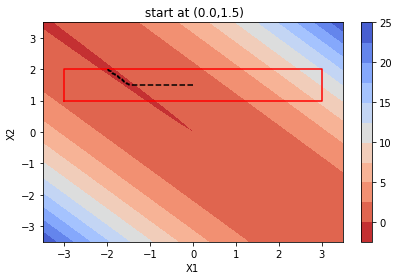

In [186]:

m=np.array([-3,1])
M=np.array([3,2])
f = lambda x: 0.5*x.T@A@x+b.T@x

#print("A:",A,"\nb:",b)

min_exact_x = exact_2d(A, b, m, M)
min_coord_x, it, all_x, all_y, all_g, all_h = coord_descent(A, b, m, M)

print(min_exact_x,min_coord_x)
#x0=np.array([m.sum()/2,M.sum()/2])
x0 = (M+m)/2
#X1, X2, Y = gen2d(0.01,-3.5,3.5,2)
if(it>1):
    plot2d(X1,X2,Y,m,M,x0,f,all_x,it,all_y,name="")
else:
    print("Only one Newton step.")
    plot2d(X1,X2,Y,m,M,x0,f,all_x,it,all_y,name="")


In [187]:
all_x

[[0.0, 1.5],
 [-1.4953952601884803, 1.5],
 [-1.4953952601884803, 1.5087956499325184],
 [-1.5041908221644993, 1.5087956499325184],
 [-1.5041908221644993, 1.5175911239529176],
 [-1.5129862082301584, 1.5175911239529176],
 [-1.5129862082301584, 1.526386422064716],
 [-1.5217814183889757, 1.526386422064716],
 [-1.5217814183889757, 1.5351815442714318],
 [-1.5305764526444694, 1.5351815442714318],
 [-1.5305764526444694, 1.543976490576583],
 [-1.5393713110001574, 1.543976490576583],
 [-1.5393713110001574, 1.5527712609836875],
 [-1.548165993459558, 1.5527712609836875],
 [-1.548165993459558, 1.5615658554962633],
 [-1.5569605000261886, 1.5615658554962633],
 [-1.5569605000261886, 1.5703602741178282],
 [-1.5657548307035674, 1.5703602741178282],
 [-1.5657548307035674, 1.5791545168519003],
 [-1.5745489854952122, 1.5791545168519003],
 [-1.5745489854952122, 1.587948583701997],
 [-1.5833429644046404, 1.587948583701997],
 [-1.5833429644046404, 1.5967424746716363],
 [-1.59213676743537, 1.5967424746716363],


In [188]:
#A, b, m, M = gen_prob(1)
m=-3
M=2
#min_exact_x = exact_2d(A, b, m, M)
min_coord_x, it, all_x, all_y, all_g, all_h = coord_descent(A, b, m, M)

print(min_coord_x)
#x0=np.array([m.sum()/2,M.sum()/2])
x0 = (M+m)/2
Xonly1=init_x(0.01,-3.5,3.5,1)
Yonly1=np.zeros((Xonly1.shape[0]))
#print(A)
for i in range(Xonly1.shape[0]):
    Yonly1[i]=f(np.matrix(Xonly1[i]))

def plot1d(X,Y,m,M,x0,f,f_input,fcount,f_y,name):
    fx1=np.zeros(fcount+1)
    fy=np.zeros(fcount+1)
    if(fcount>1):
        for i in range(fcount+1):
            if(i<=0):
                fx1[i]=x0
                fy[i]=f(x0)
            else:
                fx1[i]=f_input[0][i-1]
                fy[i]=f_y[i-1]
    else:
        for i in range(fcount+1):
            if(i<=0):
                fx1[i]=x0
                fy[i]=f(np.matrix(x0))
            else:
                fx1[i]=f_input[i-1]
                fy[i]=f_y[i-1]
    fig, ax = plt.subplots()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.plot(Xonly1,Yonly1)
    plt.scatter([m,M],[f(np.matrix(m)),f(np.matrix(M))],c='r')
    plt.plot(fx1,fy,c='k',linestyle="--")
    plt.title(name+' start at x=%.1f' %x0)
    plt.tight_layout()
    plt.savefig(name+'_1d.pdf')
    plt.show()
    print(fx1,fy)

plot1d(Xonly1,Yonly1,m,M,x0,f,all_x,it,all_y,name="")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [69]:
print(all_y)

[-0.0007868244402394775]


In [70]:
all_x

[array([0.262447])]

In [189]:
import time
f = lambda x: 0.5*x.T@A@x+b.T@x
it = []
neq = []
hs = []
gs = []
count=0
testnum=1000
for _ in range(testnum):
    A, b, m, M = gen_prob(2)
    co, i, all_co, all_y, g, h = coord_descent(A, b, m, M) #x, it, all_x, all_y, all_g, all_h
    it.append(i)
    hs.append(h)
    gs.append(g)
    ex = exact_2d(A, b, m, M)
    if (np.abs(ex-co)>=1e-5).all():
        neq.append((co, i))
    else:
        count+=1

print(count/testnum, np.mean(it), len(neq), neq)

1.0 12.687 0 []


In [190]:
def median(lst):
    lst = sorted(lst, key=len)
    med = (len(lst) - 1) // 2
    q1 = (len(lst) - 1) // 4
    q3 = med+q1 
    
    q25 = np.apply_along_axis(np.linalg.norm, 1, lst[q1])
    med = np.apply_along_axis(np.linalg.norm, 1, lst[med])
    q75 = np.apply_along_axis(np.linalg.norm, 1, lst[q3])
    
    return q25, med, q75

In [191]:
h1, hm, h3 = median(hs)
g1, gm, g3 = median(gs)

AxisError: axis 1 is out of bounds for array of dimension 1

Text(0, 0.5, '$||\\vec{h}||$')

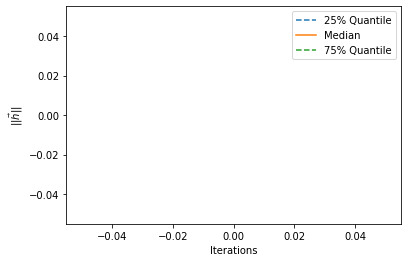

In [53]:
plt.plot(h1, linestyle='dashed', label='25% Quantile')
plt.plot(hm, label='Median')
plt.plot(h3, linestyle='dashed', label='75% Quantile')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$||\vec{h}||$')

Text(0, 0.5, '$||g||$')

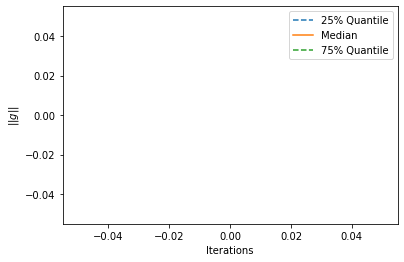

In [54]:
plt.plot(g1, linestyle='dashed', label='25% Quantile')
plt.plot(gm, label='Median')
plt.plot(g3, linestyle='dashed', label='75% Quantile')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$||g||$')

In [192]:
dims = [3,5,10,20,50]
runs = 20
max_iter = 10000

avg_iter = []
for dim in dims:
    print(dim)
    iteration_results = []
    for i in range(runs):
        A, b, m, M = gen_prob(dim)
        _, iters, _, _, _, _ = coord_descent(A, b, m, M, 1e-6,max_iter) #min_coord_x, it, all_x, all_y, all_g, all_h
        iteration_results.append(iters)
    avg_iter.append(np.average(np.array(iteration_results)))
    #plt.plot(iteration_results, label=str(dim))
#plt.legend()
#plt.show()

3
5
10
20
50


In [193]:
print(avg_iter)

[71.05, 166.9, 1000.9, 2000.8, 3000.7]


In [194]:
def cal_rate_convergence(hs):
    #h_ = np.linalg.norm(hs[-1])+1e-16
    res = []
    for i in range(len(hs)):
        if np.linalg.norm(hs[i]) < 1e-16:
            break
        print(np.linalg.norm(hs[i]),i)
        res.append((np.linalg.norm(hs[i])))
    return np.array(res)

def plot_convergence(hs, label="", name=""):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # _x = xs[-1]
    # xx = cal_convergence(xs)
    xx = cal_rate_convergence(hs)
    it = np.arange(xx.shape[0]-1)
    plt.plot(it, xx[:-1], label=label)
    # plt.legend()
    plt.yscale("log")
    plt.title('convergence rate changes '+name)
    plt.xlabel("iteration")
    plt.ylabel("||h||")
    plt.tight_layout()
    plt.savefig(name+'_converge.pdf')
    plt.show()
    plt.close('all')

[-1.         -0.09671506] [-1.         -0.09671506]


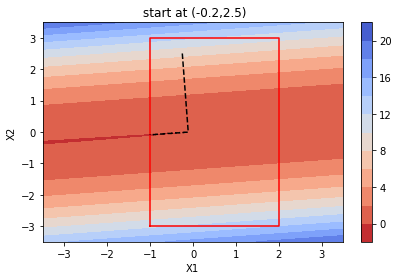

0.026369148072062476 0
0.002582802239084234 1
0.026079424363204082 2
0.002554424415048726 3
0.025792883913328696 4
0.00252635838449272 5
0.025509491747260166 6
0.002498600721671743 7
0.025229213274102397 8
0.002471148038480739 9
0.02495201428301718 10
0.002443996984040519 11
0.024677860939048415 12
0.00241714424428875 13
0.024406719778992208 14
0.002390586541575441 15
0.024138557707312356 16
0.0023643206342628723 17
0.023873341992100672 18
0.0023383433163299203 19
0.010785705633110917 20


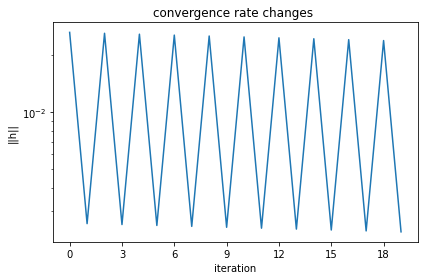

In [196]:
#A, b, m, M = gen_2d_prob()
A, b, m, M = gen_prob(2)
m=np.array([-1,-3])
M=np.array([2,3])

f = lambda x: 0.5*x.T@A@x+b.T@x

#print("A:",A,"\nb:",b)

min_exact_x = exact_2d(A, b, m, M)
min_coord_x, it, all_x, all_y, all_g, all_h = coord_descent(A, b, m, M)

print(min_exact_x,min_coord_x)
#x0=np.array([m.sum()/2,M.sum()/2])
x0 = np.array([-0.25,2.5])
X1, X2, Y = genset(0.01,-3.5,3.5,2)

if(it>1):
    plot2d(X1,X2,Y,m,M,x0,f,all_x,it,all_y,name="")
else:
    print("Only one Newton step.")
    plot2d(X1,X2,Y,m,M,x0,f,all_x,it,all_y,name="")

plot_convergence(all_h)